In [1]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')

In [ ]:
trainy = pd.read_csv("trainy_pre.csv")
valy = pd.read_csv("valy_pre.csv")
#labels to categorical matrix
le = preprocessing.LabelEncoder()
le.fit(trainy['celltype_l2'])
classes = len(np.unique(trainy['celltype_l2']))
with open("label_encoder_pre.obj","wb") as f:
   pickle.dump(le, f)

y_train = pd.DataFrame(le.transform(trainy['celltype_l2']))
y_val = pd.DataFrame(le.transform(valy['celltype_l2']))
np.save('train_pre_label.npy', y_train)
np.save('val_pre_label.npy', y_val)

In [3]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = torch.nn.functional.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * torch.nn.functional.nll_loss(log_preds, target, reduction=self.reduction)


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='checkpoint_model_pre.pth'):
        self.patience = patience    
        self.verbose = verbose      
        self.counter = 0            
        self.best_score = None      
        self.early_stop = False     
        self.val_acc_max = 0   
        self.path = path             
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None: 
            self.best_score = score 
            self.checkpoint(val_acc, model)
        elif score < self.best_score: 
            self.counter += 1 
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_acc, model)
            self.counter = 0  
    def checkpoint(self, val_acc, model):
        if self.verbose:  
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  
        self.val_acc_max = val_acc  

In [5]:
class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = np.load(img)
        self.label = torch.tensor(np.load(label))
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :] 
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        label = self.label[index]
        label = np.squeeze(label)
        return img,label
    def __len__(self):
        return self.img.shape[0]

In [6]:
def train_net(pre_epoch, EPOCH, early_patience, training_loader, validation_loader, net, optimizer, scheduler, criteria, device):
    with open("acc.txt", "w") as f:
        with open("log.txt", "w")as f2:
            start = time.time()
            earlystopping = EarlyStopping(patience=early_patience, verbose=True)
            losses_train = []
            accs_train = []
            losses_val = []
            accs_val = []
            best_acc = 0
            total_poches = 0
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                since = time.time()
                net.train()
                sum_loss = 0.0
                correct = 0
                total = 0
                for i, data in enumerate(training_loader):
                    length = len(training_loader)
                    input, target = data
                    input, target = input.to(device), target.to(device)
                    optimizer.zero_grad()
                    # forward + backward
                    output = net(input)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += predicted.eq(target.data).cpu().sum()
                    loss_train = sum_loss / (i + 1)
                    acc_train = 100. * float(correct) / float(total)
                    print('[epoch:%d, iter:%d] Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('%03d  %05d |Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('\n')
                    f2.flush()
                acc_train = 100. * float(correct) / float(total)
                accs_train.append(acc_train)
                losses_train.append(loss_train)
                print("Waiting Test!")
                with torch.no_grad():
                    sum_loss_val = 0
                    correct = 0
                    total = 0
                    loss_val = 0
                    for i, data in enumerate(validation_loader):
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criteria(outputs, labels)
                        sum_loss_val += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += predicted.eq(labels.data).cpu().sum()
                        loss_val = sum_loss_val / (i + 1)
                    acc_val = 100. * float(correct) / float(total)
                    losses_val.append(loss_val)
                    accs_val.append(acc_val)
                    print("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    scheduler.step(acc_val)
                    if acc_val > best_acc:
                        f3 = open("best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc_val))
                        f3.close()
                        best_acc = acc_val
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'loss': loss,
                    }, f'checkpoint_epoch_{epoch+1}.pth')
                    
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    earlystopping(acc_val, net)
                    if earlystopping.early_stop: 
                        print("Early Stopping!")
                        total_poches = epoch + 1
                        break
            print("Training Finished, TotalEPOCH=%d" % total_poches)
            time_total = time.time() - start
            print('The whole training process complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    return losses_train, accs_train, losses_val, accs_val

In [7]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
batch_size = 32
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
net._fc.out_features = classes
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

net = net.to(device)
# if torch.cuda.device_count() > 1:
#     net = nn.DataParallel(net)

# torch.cuda.is_available()
# torch.cuda.device_count()
# torch.cuda.current_device()
# torch.cuda.get_device_name()

Loaded pretrained weights for efficientnet-b3
Using device: mps


In [8]:
net.to(device)
net = net.to(device)

In [9]:
train = MyDataset("train_pre.npy", "train_pre_label.npy")
training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = MyDataset("val_pre.npy", "val_pre_label.npy")
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)
print(len(validation_loader))
print(len(training_loader))

79
704


In [10]:
LR = 3e-4 
# optimizer
params_to_update = net.parameters()
optimizer = optim.NAdam(params_to_update, lr=LR, betas=(0.9, 0.999), eps=1e-9)
# scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
criteria = LabelSmoothingCrossEntropy(0.1)

In [11]:
start = timer()

In [12]:
losses_train, accs_train, losses_val, accs_val = train_net(pre_epoch=0,
                                                           EPOCH = 30,
                                                           early_patience = 30,
                                                           training_loader=training_loader,
                                                           validation_loader = validation_loader,
                                                           net=net,
                                                           optimizer=optimizer,
                                                           scheduler=scheduler,
                                                           criteria=criteria,
                                                           device=device
                                                        )


Epoch: 1


[epoch:1, iter:1] Loss: 2.743 | Accuracy: 6.250% 
[epoch:1, iter:2] Loss: 2.676 | Accuracy: 14.062% 
[epoch:1, iter:3] Loss: 2.661 | Accuracy: 16.667% 
[epoch:1, iter:4] Loss: 2.609 | Accuracy: 22.656% 
[epoch:1, iter:5] Loss: 2.555 | Accuracy: 30.000% 
[epoch:1, iter:6] Loss: 2.475 | Accuracy: 40.104% 
[epoch:1, iter:7] Loss: 2.421 | Accuracy: 44.196% 
[epoch:1, iter:8] Loss: 2.360 | Accuracy: 46.875% 
[epoch:1, iter:9] Loss: 2.297 | Accuracy: 49.653% 
[epoch:1, iter:10] Loss: 2.248 | Accuracy: 51.250% 
[epoch:1, iter:11] Loss: 2.183 | Accuracy: 54.261% 
[epoch:1, iter:12] Loss: 2.127 | Accuracy: 55.990% 
[epoch:1, iter:13] Loss: 2.074 | Accuracy: 57.212% 
[epoch:1, iter:14] Loss: 2.052 | Accuracy: 56.920% 
[epoch:1, iter:15] Loss: 2.019 | Accuracy: 57.292% 
[epoch:1, iter:16] Loss: 1.974 | Accuracy: 58.398% 
[epoch:1, iter:17] Loss: 1.919 | Accuracy: 60.294% 
[epoch:1, iter:18] Loss: 1.882 | Accuracy: 61.458% 
[epoch:1, iter:19] Loss: 1.841 | Accuracy: 62.336% 
[epoch:1, iter:20] Los

In [13]:
end = timer()
print(end - start)

19924.250274499995


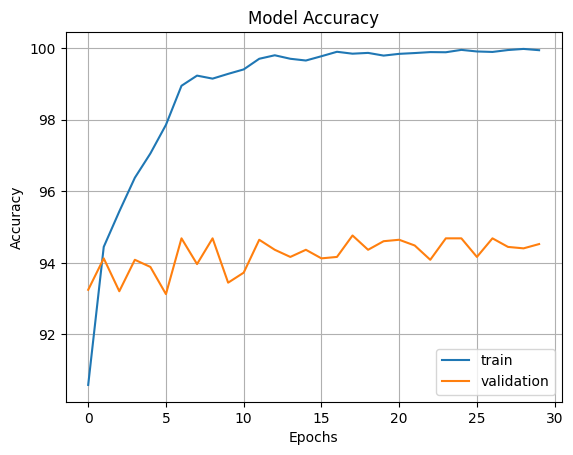

In [14]:
plt.plot(accs_train, label='Train_accuracy')
plt.plot(accs_val, label='Validation_accuracy')
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

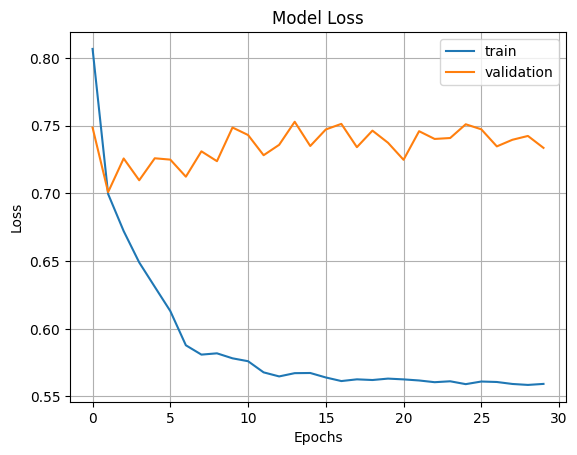

In [15]:
plt.plot(losses_train, label='Train_loss')
plt.plot(losses_val, label='Validation_loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()